<a href="https://colab.research.google.com/github/Sabeerawa05/Datasets-Practices/blob/main/poverty_pred_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cv2
import os
from imutils import paths
import random
import h5py
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.utils import to_categorical
import progressbar
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True

In [ ]:
class HDF5DatasetWriter:
    def __init__(self, dims, outputPath, dataKey="images",bufSize=1000):
        # check to see if the output path exists, and if so, raise
        # an exception
        if os.path.exists(outputPath):
            raise ValueError("The supplied ‘outputPath‘ already "
                             "exists and cannot be overwritten. Manually delete "
                             "the file before continuing.", outputPath)

        # open the HDF5 database for writing and create two datasets:
        # one to store the images/features and another to store the
        # class labels
        self.db = h5py.File(outputPath, "w")
        self.data = self.db.create_dataset(dataKey, dims,
                                           dtype="float")
        self.labels = self.db.create_dataset("labels", (dims[0], 4),
                                             dtype="float")

        # store the buffer size, then initialize the buffer itself
        # along with the index into the datasets
        self.bufSize = bufSize
        self.buffer = {"data": [], "labels": []}
        self.idx = 0

    def add(self, rows, labels):
        # add the rows and labels to the buffer
        self.buffer["data"].extend(rows)
        self.buffer["labels"].extend(labels)

        # check to see if the buffer needs to be flushed to disk
        if len(self.buffer["data"]) >= self.bufSize:
            self.flush()

    def flush(self):
        # write the buffers to disk then reset the buffer
        i = self.idx + len(self.buffer["data"])
        self.data[self.idx:i] = self.buffer["data"]
        self.labels[self.idx:i] = self.buffer["labels"]
        self.idx = i
        self.buffer = {"data": [], "labels": []}

    def storeClassLabels(self, classLabels):
        # create a dataset to store the actual class label names,
        # then store the class labels
        dt = h5py.special_dtype(vlen=str)
        labelSet = self.db.create_dataset("label_names",
                                          (len(classLabels),), dtype=dt)
        labelSet[:] = classLabels

    def close(self):
        # check to see if there are any other entries in the buffer
        # that need to be flushed to disk
        if len(self.buffer["data"]) > 0:
            self.flush()

        # close the dataset
        self.db.close()

In [ ]:
#data_path = '/content/drive/MyDrive/archive'

In [ ]:
data_path = 'satelitte_images'
train_hdf5 = 'satelitte_images/hdf5/train.hdf5'
val_hdf5 =  'satelitte_images/hdf5/val.hdf5'
test_hdf5 =  'satelitte_images/hdf5/test.hdf5'

In [ ]:
imagePaths = list(paths.list_images(data_path))

In [ ]:
imagePaths[:5]

['satelitte_images\\ethiopia_archive\\images\\10.001614493498009_38.21928274979602_10.0165864149_38.2492265926.png',
 'satelitte_images\\ethiopia_archive\\images\\10.006878190821991_37.647636949694025_9.99190626942_37.6925527139.png',
 'satelitte_images\\ethiopia_archive\\images\\10.009539116998008_39.16824952909403_10.0245110384_39.2131652933.png',
 'satelitte_images\\ethiopia_archive\\images\\10.009539116998008_39.18322145049602_10.0245110384_39.2131652933.png',
 'satelitte_images\\ethiopia_archive\\images\\10.009539116998008_39.2131652933_10.0245110384_39.2131652933.png']

In [ ]:
len(imagePaths)

56160

In [ ]:
random.seed(42)
random.shuffle(imagePaths)

In [ ]:
imagePaths[:5]

['satelitte_images\\ethiopia_archive\\images\\8.103335065686016_38.193701130798004_8.13327890849_38.2086730522.png',
 'satelitte_images\\malawi_archive\\images\\-10.739254078598007_33.55225392140199_-10.754226_33.537282.png',
 'satelitte_images\\malawi_archive\\images\\-15.781865235794024_35.142495764205975_-15.826781_35.09758.png',
 'satelitte_images\\malawi_archive\\images\\-15.735151842803985_35.136095078598004_-15.705208_35.151067.png',
 'satelitte_images\\ethiopia_archive\\images\\ethiopia_Images\\8.563866629893985_39.223355202794025_8.53392278709_39.268270967.png']

In [ ]:
imageLabels = [p.split(os.path.sep)[1] for p in imagePaths]

In [ ]:
len(imageLabels)

56160

In [ ]:
le = LabelEncoder()
imageLabels = le.fit_transform(imageLabels)

In [ ]:
classNames = [pt.split(os.path.sep)[1] for pt in imagePaths]
classNames = [str(x) for x in np.unique(classNames)]

In [ ]:
classNames

['Mali_archive', 'ethiopia_archive', 'malawi_archive', 'nigeria_archive']

In [ ]:
np.unique(imageLabels)

array([0, 1, 2, 3], dtype=int64)

In [ ]:
imageLabels = to_categorical(imageLabels, len(classNames))

In [ ]:
imageLabels

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [ ]:
# perform stratified sampling from the training set to build the
 # testing split from the training data
split = train_test_split(imagePaths, imageLabels,
                         test_size=0.10, stratify=imageLabels,  random_state=42)

(trainPaths, testPaths, trainLabels, testLabels) = split

# perform another stratified sampling, this time to build the
# validation data
split = train_test_split(trainPaths, trainLabels,
                         test_size=0.15, stratify=trainLabels,random_state=42)

(trainPaths, valPaths, trainLabels, valLabels) = split

In [ ]:
# construct a list pairing the training, validation, and testing
# image paths along with their corresponding labels and output HDF5
# files
datasets = [("train", trainPaths, trainLabels, train_hdf5),
            ("val", valPaths, valLabels, val_hdf5),
            ("test", testPaths, testLabels, test_hdf5)]

In [ ]:
# loop over the dataset tuples
for (dType, paths, labels, outputPath) in datasets:
    # create HDF5 writer
    print("[INFO] building {}...".format(outputPath))
    writer = HDF5DatasetWriter((len(paths), 224, 224, 3), outputPath)

    # initialize the progress bar
    widgets = ["Building Dataset: ", progressbar.Percentage(), " ",
               progressbar.Bar(), " ", progressbar.ETA()]
    pbar = progressbar.ProgressBar(maxval=len(paths),
                                   widgets=widgets).start()

    # loop over the image paths
    for (i, (path, label)) in enumerate(zip(paths, labels)):
        # load the image and process it
        image = cv2.imread(path)
        #image = cv2.resize(image, (256, 256),
                         interpolation=cv2.INTER_AREA)

        image = image.astype('float')/255.0

        # add the image and label # to the HDF5 dataset
        writer.add([image], [label])
        pbar.update(i)

    # close the HDF5 writer
    pbar.finish()
    writer.close()


[INFO] building satelitte_images/hdf5/train_224.hdf5...


Building Dataset: 100% |########################################| Time: 0:27:25


[INFO] building satelitte_images/hdf5/val_224.hdf5...


Building Dataset: 100% |########################################| Time: 0:04:13


[INFO] building satelitte_images/hdf5/test_224.hdf5...


Building Dataset: 100% |########################################| Time: 0:03:02


In [ ]:
def read_hdf5(dir):
    db = h5py.File(dir, mode='r')

    return db

In [ ]:
train_data = read_hdf5(train_hdf5)

In [ ]:
list(train_data.keys())

['images', 'labels']

In [ ]:
train_data['images'].shape

(42962, 224, 224, 3)

In [ ]:
train_data['labels'].shape

(42962, 4)

In [ ]:
val_data = read_hdf5(val_hdf5)

In [ ]:
test_data = read_hdf5(test_hdf5)

In [ ]:
train_data['images'][0:32].shape


(32, 256, 256, 3)

In [ ]:
class HDF5DatasetGenerator:

    def __init__(self, dbPath, batchSize):

        # store the batch size, preprocessors, and data augmentor,
        # whether or not the labels should be binarized, along with
        # the total number of classes
        self.batchSize = batchSize


        # open the HDF5 database for reading and determine the total
        # number of entries in the database
        self.db = h5py.File(dbPath, mode='r')
        self.numImages = self.db["labels"].shape[0]


    def generator(self, passes=np.inf):
        # initialize the epoch count
        epochs = 0

        # keep looping infinitely -- the model will stop once we have
        # reach the desired number of epochs
        while epochs < passes:
            # loop over the HDF5 dataset
            for i in np.arange(0, self.numImages, self.batchSize):
                # extract the images and labels from the HDF dataset
                images = self.db["images"][i: i + self.batchSize]
                labels = self.db["labels"][i: i + self.batchSize]

                # yield a tuple of images and labels
                yield (images, labels)

    def close(self):
        # close the database
        self.db.close()

In [ ]:
# initialize the training and validation dataset generators
trainGen = HDF5DatasetGenerator(train_hdf5, 8)
valGen = HDF5DatasetGenerator(val_hdf5, 8)
testGen = HDF5DatasetGenerator(test_hdf5, 8)

## VGG16 Model

In [ ]:
from keras.layers import Input
from keras.models import Model
from keras.applications import VGG16
from keras.optimizers import RMSprop
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.models import load_model
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers.core import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.layers import AveragePooling2D
from keras.models import load_model

In [ ]:
# load VGG16, ensuring the head FC layer sets are left off, while at
# the same time adjusting the size of the input image tensor to the
# network
# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False,
                  input_tensor=Input(shape=(256, 256, 3)))
#print(baseModel.summary())

In [ ]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(4096, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(classNames), activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
VGGModel = Model(inputs=baseModel.input, outputs=headModel)


In [ ]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [ ]:
#VGGModel.summary()

In [ ]:
# compile our model (this needs to be done after our setting our
# layers to being non-trainable
print("[INFO] compiling model...")

# compile the model
epochs = 200
lr = 1e-4
opt = Adam(lr=lr, decay=lr / epochs)
VGGModel.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])


[INFO] compiling model...


In [ ]:
mcp = ModelCheckpoint(filepath='satelitte_models/weights/vggmodel_weight.h5', save_weights_only=True,
                     monitor="val_loss",  verbose=1)

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

In [ ]:
csv_log = CSVLogger('satelitte_models/train_log/vgg_training.csv', separator=',',append=True)

In [ ]:
trainGen.numImages

42962

In [ ]:
# train the head of the network for a few epochs (all other
# layers are frozen)
print("[INFO] training head...")
H = VGGModel.fit(x = trainGen.generator(),
                 validation_data=valGen.generator(),
                 steps_per_epoch=trainGen.numImages // 8,
                 validation_steps=valGen.numImages // 8,
                 batch_size=8,
                 epochs=epochs, callbacks=[es, mcp, csv_log], verbose=1)

[INFO] training head...
Epoch 1/200
5370/5370 [==============================] - 727s 135ms/step - loss: 0.9666 - accuracy: 0.6032 - val_loss: 0.8848 - val_accuracy: 0.6465

Epoch 00001: saving model to satelitte_models/weights\vggmodel_weight.h5
Epoch 2/200
5370/5370 [==============================] - 725s 135ms/step - loss: 0.8933 - accuracy: 0.6372 - val_loss: 0.8410 - val_accuracy: 0.6641

Epoch 00002: saving model to satelitte_models/weights\vggmodel_weight.h5
Epoch 3/200
5370/5370 [==============================] - 721s 134ms/step - loss: 0.8423 - accuracy: 0.6626 - val_loss: 0.7965 - val_accuracy: 0.6899

Epoch 00003: saving model to satelitte_models/weights\vggmodel_weight.h5
Epoch 4/200
5370/5370 [==============================] - 747s 139ms/step - loss: 0.8042 - accuracy: 0.6810 - val_loss: 0.7881 - val_accuracy: 0.6827

Epoch 00004: saving model to satelitte_models/weights\vggmodel_weight.h5
Epoch 5/200
5370/5370 [==============================] - 736s 137ms/step - loss: 0.7

In [ ]:
# compile our model (this needs to be done after our setting our
# layers to being non-trainable
print("[INFO] compiling model...")

# compile the model
epochs = 100
lr = 1e-4
opt = Adam(lr=lr, decay=lr / epochs)
VGGModel.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])

[INFO] compiling model...


In [ ]:
VGGModel.load_weights('satelitte_models/weights/vggmodel_weight.h5')

In [ ]:
mcp = ModelCheckpoint(filepath='satelitte_models/weights/vggmodel_weight.h5', save_weights_only=True,
                     monitor="val_loss",  verbose=1)

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)

In [ ]:
csv_log = CSVLogger('satelitte_models/train_log/vgg_training.csv', separator=',',append=True)

In [ ]:
import pandas as pd

In [ ]:
history = pd.read_csv('satelitte_models/train_log/vgg_training.csv')

In [ ]:
history

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.613385,0.946528,0.646515,0.884753
1,1,0.642804,0.880817,0.664071,0.841020
2,2,0.664711,0.834268,0.689942,0.796501
3,3,0.682055,0.797741,0.682682,0.788103
4,4,0.694604,0.769662,0.691922,0.772582
...,...,...,...,...,...
90,90,0.900941,0.252816,0.866948,0.442470
91,91,0.902850,0.250037,0.859953,0.452306
92,92,0.904456,0.249095,0.860744,0.449079
93,93,0.903175,0.247544,0.857709,0.467973


In [ ]:
#history.to_dict('list')

In [ ]:
# continue training the head of the network for a few epochs (all other
# layers are frozen)
print("[INFO] training head...")
H = VGGModel.fit(x = trainGen.generator(),
                 validation_data=valGen.generator(),
                 steps_per_epoch=trainGen.numImages // 8,
                 validation_steps=valGen.numImages // 8,
                 batch_size=8,
                 epochs=epochs, initial_epoch= 95, callbacks=[es, mcp, csv_log], verbose=1)

[INFO] training head...
Epoch 96/100
5370/5370 [==============================] - 759s 139ms/step - loss: 0.2475 - accuracy: 0.9048 - val_loss: 0.5006 - val_accuracy: 0.8444

Epoch 00096: saving model to satelitte_models/weights\vggmodel_weight.h5
Epoch 97/100
5370/5370 [==============================] - 719s 134ms/step - loss: 0.2506 - accuracy: 0.9009 - val_loss: 0.4518 - val_accuracy: 0.8654

Epoch 00097: saving model to satelitte_models/weights\vggmodel_weight.h5
Epoch 98/100
5370/5370 [==============================] - 720s 134ms/step - loss: 0.2470 - accuracy: 0.9026 - val_loss: 0.4760 - val_accuracy: 0.8543

Epoch 00098: saving model to satelitte_models/weights\vggmodel_weight.h5
Epoch 99/100
5370/5370 [==============================] - 708s 132ms/step - loss: 0.2415 - accuracy: 0.9075 - val_loss: 0.4807 - val_accuracy: 0.8561

Epoch 00099: saving model to satelitte_models/weights\vggmodel_weight.h5
Epoch 100/100
5370/5370 [==============================] - 726s 135ms/step - los

In [ ]:
# saving model
VGGModel.save('satelitte_models/vgg_model_satelitte.h5')

In [ ]:
# train the head of the network for a few epochs (all other
# layers are frozen)
print("[INFO] training head...")
'''H = VGGModel.fit(x = trainGen.generator(),
                 validation_data=valGen.generator(),
                 steps_per_epoch=trainGen.numImages // 8,
                 validation_steps=valGen.numImages // 8,
                 batch_size=8,
                 epochs=epochs, callbacks=es, verbose=1)'''

[INFO] training head...


'H = VGGModel.fit(x = trainGen.generator(),\n                 validation_data=valGen.generator(),\n                 steps_per_epoch=trainGen.numImages // 8,\n                 validation_steps=valGen.numImages // 8,\n                 batch_size=8,\n                 epochs=epochs, callbacks=es, verbose=1)'

In [ ]:
# saving model
#VGGModel.save('satelitte_models/vgg_model_satelitte.h5')

In [ ]:
history = pd.read_csv('satelitte_models/train_log/vgg_training.csv')

In [ ]:
VGGHist = history.to_dict('list')

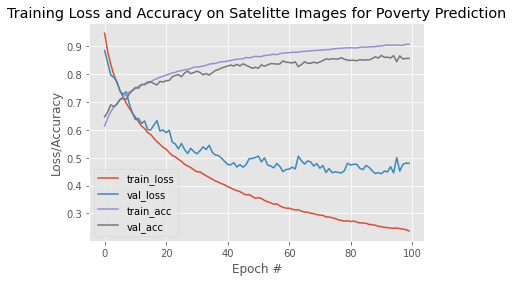

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(VGGHist["loss"], label="train_loss")
plt.plot(VGGHist["val_loss"], label="val_loss")
plt.plot(VGGHist["accuracy"], label="train_acc")
plt.plot(VGGHist["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Satelitte Images for Poverty Prediction")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [ ]:
testGen.numImages

In [ ]:
num_pred = (testGen.numImages // 8) * 8
num_pred

5616

In [ ]:
# evaluate the network
print("[INFO] evaluating network...")
num_pred = (testGen.numImages // 8) * 8
predictions = VGGModel.predict(testGen.generator(passes=1),
                                      steps=testGen.numImages // 8)
y_pred = predictions.argmax(axis=-1)
y_true = test_data['labels'][...].argmax(axis=-1)[:num_pred]
print(classification_report(y_true, y_pred,
                            target_names=classNames))
#predictions = model.predict(testX, batch_size=32)
#print(classification_report(testY.argmax(axis=1),
                            #predictions.argmax(axis=1), target_names=classNames))

[INFO] evaluating network...
                  precision    recall  f1-score   support

    Mali_archive       0.79      0.91      0.85      1475
ethiopia_archive       0.92      0.92      0.92      1717
  malawi_archive       0.91      0.83      0.87      1270
 nigeria_archive       0.85      0.76      0.80      1154

        accuracy                           0.87      5616
       macro avg       0.87      0.86      0.86      5616
    weighted avg       0.87      0.87      0.87      5616



In [ ]:
#VGGLoaded = load_model('satelitte_models/vgg_model_satelitte.h5')

In [ ]:
VGGLoaded = load_model('satelitte_models/weights/vggmodel_weight_model1.h5')

## UNFREZZING FINAL SET OF CONV LAYERS IN VGG16 MODEL - 1

In [ ]:
# now that the head FC layers have been trained/initialized, lets
# unfreeze the final set of CONV layers and make them trainable
for layer in baseModel.layers[15:]:
    layer.trainable = True

In [ ]:
# compile our model (this needs to be done after our setting our
# layers to being non-trainable
print("[INFO] compiling model...")

# compile the model
epochs = 100
lr = 1e-4
opt = Adam(lr=lr, decay=lr / epochs)
VGGLoaded.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])

[INFO] compiling model...


In [ ]:
mcp = ModelCheckpoint(filepath='satelitte_models/weights/vggmodel_weight_model1.h5', save_best_only=True,
                     monitor="val_loss",  verbose=1)

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

In [ ]:
csv_log = CSVLogger('satelitte_models/train_log/vgg_training1.csv', separator=',',append=True)

In [ ]:
trainGen.numImages

42962

In [ ]:
# train the head of the network for a few epochs (all other
# layers are frozen)
print("[INFO] training head and convollutional layer...")
H = VGGLoaded.fit(x = trainGen.generator(),
                 validation_data=valGen.generator(),
                 steps_per_epoch=trainGen.numImages // 8,
                 validation_steps=valGen.numImages // 8,
                 batch_size=8,
                 epochs=epochs, callbacks=[es, mcp, csv_log], verbose=1)

[INFO] training head and convollutional layer...
Epoch 1/100
5370/5370 [==============================] - 747s 139ms/step - loss: 0.2396 - accuracy: 0.9053 - val_loss: 0.4732 - val_accuracy: 0.8611

Epoch 00001: val_loss improved from inf to 0.47324, saving model to satelitte_models/weights\vggmodel_weight_model1.h5
Epoch 2/100
5370/5370 [==============================] - 737s 137ms/step - loss: 0.2333 - accuracy: 0.9089 - val_loss: 0.5031 - val_accuracy: 0.8516

Epoch 00002: val_loss did not improve from 0.47324
Epoch 3/100
5370/5370 [==============================] - 713s 133ms/step - loss: 0.2347 - accuracy: 0.9084 - val_loss: 0.4484 - val_accuracy: 0.8644

Epoch 00003: val_loss improved from 0.47324 to 0.44840, saving model to satelitte_models/weights\vggmodel_weight_model1.h5
Epoch 4/100
5370/5370 [==============================] - 727s 135ms/step - loss: 0.2340 - accuracy: 0.9079 - val_loss: 0.4678 - val_accuracy: 0.8606

Epoch 00004: val_loss did not improve from 0.44840
Epoch 5

In [ ]:
# compile our model (this needs to be done after our setting our
# layers to being non-trainable
print("[INFO] compiling model...")

# compile the model
epochs = 100
lr = 1e-4
opt = Adam(lr=lr, decay=lr / epochs)
VGGModel.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])

[INFO] compiling model...


In [ ]:
VGGModel.load_weights('satelitte_models/weights/vggmodel_weight1.h5')

In [ ]:
mcp = ModelCheckpoint(filepath='satelitte_models/weights/vggmodel_weight1.h5', save_weights_only=True,
                     monitor="val_loss",  verbose=1)

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)

In [ ]:
csv_log = CSVLogger('satelitte_models/train_log/vgg_training1.csv', separator=',',append=True)

In [ ]:
import pandas as pd

In [ ]:
history = pd.read_csv('satelitte_models/train_log/vgg_training1.csv')

In [ ]:
history

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.905261,0.239583,0.861140,0.473235
1,1,0.908903,0.233339,0.851637,0.503111
2,2,0.908390,0.234718,0.864440,0.448402
3,3,0.907948,0.233969,0.860612,0.467788
4,4,0.910020,0.230232,0.852033,0.488536
5,5,0.910509,0.229544,0.859688,0.472573
6,6,0.909717,0.226757,0.860480,0.468518
7,7,0.910742,0.225938,0.862196,0.455837
8,8,0.910975,0.226398,0.866816,0.455020
9,9,0.913349,0.221468,0.868664,0.456677


In [ ]:
H = history.to_dict('list')

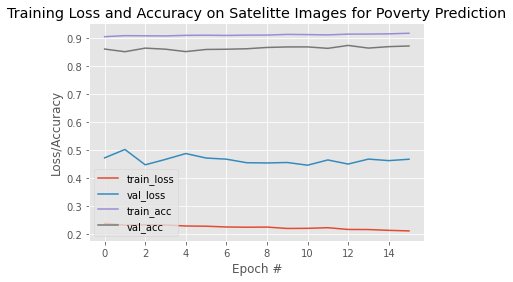

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H["loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.plot(H["accuracy"], label="train_acc")
plt.plot(H["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Satelitte Images for Poverty Prediction")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [ ]:
testGen.numImages

In [ ]:
num_pred = (testGen.numImages // 8) * 8
num_pred

In [ ]:
# evaluate the network
print("[INFO] evaluating network...")
num_pred = (testGen.numImages // 8) * 8
predictions =  VGGLoaded.predict(testGen.generator(passes=1),
                                      steps=testGen.numImages // 8)
y_pred = predictions.argmax(axis=-1)
y_true = test_data['labels'][...].argmax(axis=-1)[:num_pred]
print(classification_report(y_true, y_pred,
                            target_names=classNames))
#predictions = model.predict(testX, batch_size=32)
#print(classification_report(testY.argmax(axis=1),
                            #predictions.argmax(axis=1), target_names=classNames))

[INFO] evaluating network...
                  precision    recall  f1-score   support

    Mali_archive       0.81      0.91      0.86      1475
ethiopia_archive       0.93      0.92      0.92      1717
  malawi_archive       0.88      0.88      0.88      1270
 nigeria_archive       0.87      0.77      0.82      1154

        accuracy                           0.87      5616
       macro avg       0.87      0.87      0.87      5616
    weighted avg       0.88      0.87      0.87      5616

